<a href="https://colab.research.google.com/github/hushee69/biobert-relation-extraction/blob/main/euadr_dataset_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# datasets link: https://drive.google.com/open?id=1-jDKGcXREb2X9xTFnuiJ36PvsqoyHWcw

!pip install transformers

In [2]:
import numpy as np;
import pandas as pd;

import torch;

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig;
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler;
from transformers import get_linear_schedule_with_warmup;

from sklearn.metrics import precision_score, recall_score, f1_score;

In [3]:
from google.colab import drive;

drive.mount('/content/gdrive');

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path='/content/gdrive/MyDrive/biobert_re/';

In [5]:
device = torch.device('cuda');

In [6]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten();
    labels = labels.flatten();

    return np.sum(preds == labels) / len(labels);

In [7]:
"""
    Params:
        filepath: path of the dataset
        tokenizer: tokenizer to use
        maxlen: maxlength of text
"""
def load_and_process_euadr_train_data(filepath, tokenizer, maxlen=512, train_percentage=0.7):
    # load dataset
    df = pd.read_csv(filepath, header=None, delimiter='\t', names=['sentence', 'label']);

    sentences = df.sentence.values;
    labels = df.label.values;
    
    input_ids = [];
    attention_masks = [];
    
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        );

        input_ids.append(encoded_dict['input_ids']);
        attention_masks.append(encoded_dict['attention_mask']);

    # convert lists into tensors
    input_ids = torch.cat(input_ids, dim=0);
    attention_masks = torch.cat(attention_masks, dim=0);
    labels_tensor = torch.tensor(labels);

    dataset = TensorDataset(input_ids, attention_masks, labels_tensor);

    train_size = int(train_percentage * len(dataset));
    val_size = len(dataset) - train_size;

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]);

    return (train_dataset, val_dataset);

In [8]:
def train_euadr_model(model, data, optimizer=AdamW, batch_size=32, epochs=3):
    max_val_loss = np.float('inf');

    train_ds = data[0];
    val_ds = data[1];

    train_dataloader = DataLoader(
        train_ds,
        sampler=RandomSampler(train_ds),
        batch_size=batch_size
    );

    val_dataloader = DataLoader(
        val_ds,
        sampler=SequentialSampler(val_ds),
        batch_size=batch_size
    );

    for e in range(epochs):
        train_loss = 0;
        train_acc = 0;

        model.train();

        optim = optimizer(model.parameters(), lr=2e-5, eps=1e-8);

        scheduler = get_linear_schedule_with_warmup(
            optim,
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader) * epochs
        );

        for batch in train_dataloader:
            b_input_ids = batch[0].to(device);
            b_input_mask = batch[1].to(device);
            b_labels = batch[2].to(device);

            model.zero_grad();

            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            );

            loss = output['loss'];
            preds = output['logits'].detach().cpu().numpy();
            labels = b_labels.to('cpu').numpy();

            train_loss += loss.item();
            train_acc += accuracy(preds, labels);

            loss.backward();

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0);

            optim.step();

            scheduler.step();
        
        avg_train_loss = train_loss / len(train_dataloader);
        avg_train_acc = train_acc / len(train_dataloader);

        print('average training loss for epoch: {}'.format(avg_train_loss));
        print('average training accuracy for epoch: {}'.format(avg_train_acc));

        # validation
        val_loss = 0;
        val_acc = 0;

        model.eval();

        for batch in val_dataloader:
            b_input_ids = batch[0].to(device);
            b_attention_mask = batch[1].to(device);
            b_labels = batch[2].to(device);

            with torch.no_grad():
                output = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_attention_mask,
                    labels=b_labels
                );
            
            loss = output['loss'];
            preds = output['logits'].detach().cpu().numpy();
            labels = b_labels.to('cpu').numpy();

            val_loss += loss.item();
            val_acc += accuracy(preds, labels);
        
        avg_val_loss = val_loss / len(val_dataloader);
        avg_val_acc = val_acc / len(val_dataloader);

        if avg_val_loss < max_val_loss:
            max_val_loss = avg_val_loss;
            torch.save(model.state_dict(), 'best_model.pt');

        print('average validation loss for epoch: {}'.format(avg_val_loss));
        print('average validation accuracy for epoch: {}'.format(avg_val_acc));

**Training EU-ADR**

Since there is not much data in EU-ADR dataset, we chose to have 3 epochs so as to prevent overfitting of data. This decision was not experimental since the authors advise fine-tuning using 2-4 epochs.

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
);

device = torch.device('cuda');
model.cuda();

epochs = 2;

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
for i in range(10):
    data = load_and_process_euadr_train_data(path + 'euadr/' + str(i + 1) + '/train.tsv', tokenizer=tokenizer, maxlen=128);
    train_euadr_model(model, data);

average training loss for epoch: 0.60955639396395
average training accuracy for epoch: 0.6761904761904762
average validation loss for epoch: 0.4938584864139557
average validation accuracy for epoch: 0.7916666666666666
average training loss for epoch: 0.5597275580678668
average training accuracy for epoch: 0.7208333333333333
average validation loss for epoch: 0.4805082579453786
average validation accuracy for epoch: 0.7916666666666666
average training loss for epoch: 0.5079634402479444
average training accuracy for epoch: 0.7473214285714286
average validation loss for epoch: 0.45255379875500995
average validation accuracy for epoch: 0.8229166666666666
average training loss for epoch: 0.49522543804986136
average training accuracy for epoch: 0.7663690476190476
average validation loss for epoch: 0.4159041841824849
average validation accuracy for epoch: 0.8125
average training loss for epoch: 0.46038676159722464
average training accuracy for epoch: 0.7964285714285715
average validation loss

In [ ]:
from IPython.display import display;

In [ ]:
"""
    Params:
        filepath: path of the dataset
        tokenizer: tokenizer to use
        maxlen: maxlength of text
"""
def load_and_process_euadr_test_data(filepath, tokenizer, maxlen=512):
    # load dataset
    df = pd.read_csv(filepath, delimiter='\t', header=None, names=['wrong_index', 'sentence', 'label']);

    sentences = df.sentence.values;
    labels = df.label.values;
    
    input_ids = [];
    attention_masks = [];
    
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        );

        input_ids.append(encoded_dict['input_ids']);
        attention_masks.append(encoded_dict['attention_mask']);

    # convert lists into tensors
    input_ids = torch.cat(input_ids, dim=0);
    attention_masks = torch.cat(attention_masks, dim=0);
    labels_tensor = torch.tensor(labels);

    dataset = TensorDataset(input_ids, attention_masks, labels_tensor);

    return dataset;

In [ ]:
def test_euadr_model(model, data, batch_size=32):
    model.load_state_dict(torch.load('best_model.pt'));

    model.eval();

    ds = data;

    test_dataloader = DataLoader(
        ds,
        sampler=SequentialSampler(ds),
        batch_size=batch_size,
    );

    preds_list, real_labels_list = [], [];

    total_accuracy_for_file = 0;
    total_precision_for_file = 0;
    total_recall_for_file = 0;
    total_f1_score_for_file = 0;

    for batch_nbr, batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device);
        b_input_mask = batch[1].to(device);
        b_labels = batch[2].to(device);

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            );
        
        logits = outputs['logits'].detach().cpu().numpy();
        label_ids = b_labels.to('cpu').numpy();
        preds = np.argmax(logits, axis=1);

        preds_list.append(preds);
        real_labels_list.append(real_labels_list);

        print('real: {}'.format(label_ids));
        print('preds: {}'.format(preds));
        print();
        
        batch_acc = accuracy(logits, label_ids);
        total_accuracy_for_file += batch_acc;
        
        batch_precision = precision_score(label_ids, preds);
        total_precision_for_file += batch_precision;

        batch_recall = recall_score(label_ids, preds);
        total_recall_for_file += batch_recall;

        batch_f1 = f1_score(label_ids, preds);
        total_f1_score_for_file += batch_f1;

        print('accuracy for batch {}: {}'.format(batch_nbr, batch_acc));
        print('precision for batch {}: {}'.format(batch_nbr, batch_precision));
        print('recall for batch {}: {}'.format(batch_nbr, batch_recall));
        print('f1 score for batch {}: {}'.format(batch_nbr, batch_f1));
    
    #preds_list_np = np.concatenate(preds_list); # predictions
    #real_labels_list_np = np.concatenate(real_labels_list); # real labels
    print('calculating scores over {} batches'.format(len(test_dataloader)));
    ret = (
        total_accuracy_for_file / len(test_dataloader),
        total_precision_for_file / len(test_dataloader),
        total_recall_for_file / len(test_dataloader),
        total_f1_score_for_file / len(test_dataloader)
    );
    
    return ret;

In [ ]:
# load test_accumulated.tsv file
avg_test_accuracy = 0;

test_data = load_and_process_euadr_test_data(path + 'euadr/test_accumulated.tsv', tokenizer=tokenizer);
print('length of test datafile: '.format(test_data));

ret = test_euadr_model(model, test_data);

In [ ]:
total_accuracy_for_files = 0;
total_precision_for_files = 0;
total_recall_for_files = 0;
total_f1_score_for_files = 0;

preds_list_all_files = [];
real_labels_list_all_files = [];

for i in range(10):
    data = load_and_process_euadr_test_data(path + 'euadr/' + str(i + 1) + '/test.tsv', tokenizer=tokenizer, maxlen=128);
    ret = test_euadr_model(model, data);
    total_accuracy_for_files += ret[0];
    total_precision_for_files += ret[1];
    total_recall_for_files += ret[2];
    total_f1_score_for_files += ret[3];

    #preds_list_all_files.append(ret[4]);
    #real_labels_list_all_files.append(ret[5]);

    print();
    print('accuracy for file {}: {}'.format((i + 1), ret[0]));
    print('precision for file {}: {}'.format((i + 1), ret[1]));
    print('recall for file {}: {}'.format((i + 1), ret[2]));
    print('f1 score for file {}: {}'.format((i + 1), ret[3]));
    print();
    print();

# 10 files
print('test accuracy for all files: {}%'.format(((total_accuracy_for_files) / 10) * 100));
print('test precision for all files: {}%'.format(((total_precision_for_files) / 10) * 100));
print('test recall for all files: {}%'.format(((total_recall_for_files) / 10) * 100));
print('test f1 score for all files: {}%'.format(((total_f1_score_for_files) / 10) * 100));

print('all files predictions', preds_list_all_files);

**Previous F1-Score of State of the Art with EU-ADR dataset: 86.51%**

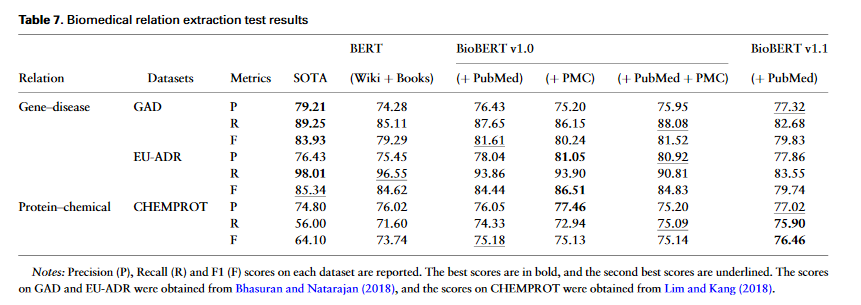

Source: https://arxiv.org/ftp/arxiv/papers/1901/1901.08746.pdf

**State of the Art with EU-ADR dataset with this BERT model: 98.02%**

In [ ]:
# https://stackoverflow.com/questions/49873676/how-to-calculate-the-average-of-training-accuracy-in-keras